<a href="https://colab.research.google.com/github/MoonjeongWoo/tensorflow/blob/main/Cartpole_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
python-dev is already the newest version (2.7.15~rc1-1).
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-numpy set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libboost-all-dev is already the newest version (1.65.1.0ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following additional packages will be installed:
  gir1.2-ibus-1.0 libcapnp-0.6.1 libdbus-1-dev libdmx-dev libdmx1
  libfontenc-dev libfs-dev libfs6 libibus-1.0-5 libibus-1.0-dev
  libmirclient-dev libmirclient9 libmircommon-dev libmircommon7
  libmircookie-dev libmircookie2 libmircore-dev libmircore1 libmirprotobuf3
  libpciaccess-dev libpixman-1-dev libprotobuf-dev libprotobuf-lite10
  libpulse-dev libpu

In [ ]:
!pip install pyvirtualdisplay
!pip install piglet

     |████████████████████████████████| 67 kB 3.0 MB/s 


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import numpy as np
import tensorflow as tf
import gym
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
from glob import glob
from base64 import b64encode
from IPython.display import HTML
from IPython import display as ipy_display
from gym import logger as gym_logger


np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.001,
            reward_decay=0.9,
            e_greedy=0.8,
            replace_target_iter=200,
            memory_size=3000,
            batch_size=32,
            e_greedy_increment=0.0002,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, update_net]
        self._build_net()

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build update_net ------------------
        self.s = tf.placeholder(shape = [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        n_l1 = 30
        with tf.variable_scope('update_net'):
            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], 
                                     initializer=tf.random_normal_initializer(0., 0.3), 
                                     collections=['update_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                b1 = tf.get_variable('b1', [1, n_l1], 
                                     initializer=tf.constant_initializer(0.1), 
                                     collections=['update_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], 
                                     initializer=tf.random_normal_initializer(0., 0.3), 
                                     collections=['update_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                b2 = tf.get_variable('b2', [1, self.n_actions], 
                                     initializer=tf.constant_initializer(0.1), 
                                     collections=['update_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                self.q_update = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_update))
        with tf.variable_scope('train'):
            self._train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], 
                                     initializer=tf.random_normal_initializer(0., 0.3),
                                     collections=['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                b1 = tf.get_variable('b1', [1, n_l1], 
                                     initializer=tf.constant_initializer(0.1), 
                                     collections=['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], 
                                     initializer=tf.random_normal_initializer(0., 0.3),
                                     collections=['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                b2 = tf.get_variable('b2', [1, self.n_actions], 
                                     initializer=tf.constant_initializer(0.1), 
                                     collections=['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES])
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_update, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def _replace_target_params(self):
        t_params = tf.get_collection('target_net_params')
        u_params = tf.get_collection('update_net_params')
        self.sess.run([tf.assign(t, u) for t, u in zip(t_params, u_params)])

    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self._replace_target_params()
            #print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_update = self.sess.run([self.q_next, self.q_update], 
                        feed_dict={self.s_: batch_memory[:, -self.n_features:],  # fixed params
                                   self.s: batch_memory[:, :self.n_features]})   # newest params
                                    

        # change q_target w.r.t q_update's action
        q_target = q_update.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        update_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, update_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        # train update network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

In [ ]:
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [ ]:
env = wrap_env(gym.make('MountainCar-v0'))

In [ ]:
print(env.action_space)
print(env.observation_space.shape)

Discrete(3)
(2,)


In [ ]:
RL = DeepQNetwork(n_actions=env.action_space.n,
                  n_features=env.observation_space.shape[0],
                  learning_rate=0.001, 
                  e_greedy=0.8,
                  replace_target_iter=200, 
                  memory_size=3000,
                  e_greedy_increment=0.0002)

AttributeError: ignored

In [ ]:
total_steps = 0

In [ ]:
for episode in range(100):

    observation = env.reset()
    ep_r = 0
    while True:
        env.render()

        action = RL.choose_action(observation)

        observation_, reward, done, info = env.step(action)

        # the smaller theta and closer to center the better
        x, dx, theta, dtheta = observation_
        r1 = (env.x_threshold - abs(x))/env.x_threshold +0.5
        r2 = (env.theta_threshold_radians - abs(theta))/env.theta_threshold_radians + 0.5
        reward = r1 + r2

        RL.store_transition(observation, action, reward, observation_)

        ep_r += reward
        if total_steps > 500:
            RL.learn()

        if done:
            print('episode: ', episode,
                  ' reward: ', round(ep_r, 2),
                  ' epsilon: ', round(RL.epsilon, 2))
            break

        observation = observation_
        total_steps += 1

env.close()

NameError: ignored

In [ ]:
def show_video():
    mp4_list = glob('video/*.mp4')
    print(mp4_list)
    if mp4_list:
        mp4 = mp4_list[0]
        video = open(mp4, 'r+b').read()
        encoded = b64encode(video)
        ipy_display.display(HTML(data='''
            <video alt="gameplay" autoplay controls style="height: 400px;">
                <source src="data:video/mp4;base64,%s" type="video/mp4" />
            </video>
        ''' % (encoded.decode('ascii'))))
    else:
        print('No video found')

In [ ]:
show_video()

['video/openaigym.video.0.71.video000064.mp4', 'video/openaigym.video.0.71.video000008.mp4', 'video/openaigym.video.0.71.video000027.mp4', 'video/openaigym.video.0.71.video000000.mp4', 'video/openaigym.video.0.71.video000001.mp4']


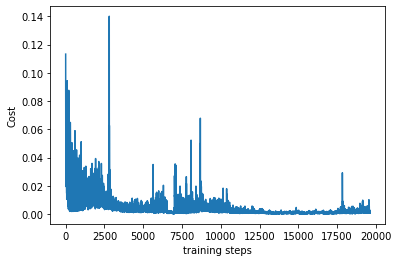

In [ ]:
RL.plot_cost()